In [ ]:
dataset_name = "Departures"
pdf_path = "data/raw/MadridBarajasDeparturesShort.pdf"

In [10]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# PDF processing
import pdfplumber

# Regular expressions for text processing
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time handling
from datetime import datetime, timedelta

In [11]:
def clean_time(time_str):
    """Clean corrupted time strings from PDF extraction"""
    # Extract only digits and colon
    digits_only = ''.join(char for char in time_str if char.isdigit() or char == ':')
    
    # Try to find a time pattern (HH:MM)
    time_match = re.search(r'(\d{1,2}):(\d{2})', digits_only)
    
    if time_match:
        hours, minutes = map(int, time_match.groups())
        # Validate hours and minutes
        if 0 <= hours <= 23 and 0 <= minutes <= 59:
            return f"{hours:02d}:{minutes:02d}"
    return None

def clean_airline_name(parts):
    """Clean airline name by removing registration numbers and status tags"""
    # Pattern for registration numbers and other tags in parentheses
    tag_pattern = r'\([^)]+\)'
    # Join parts and remove any parenthetical content
    airline_name = ' '.join(parts)
    return re.sub(tag_pattern, '', airline_name).strip()

import sqlite3
from datetime import datetime

def extract_flights_from_pdf(pdf_path):
    """Extract flight information from PDF file and return as DataFrame"""
    flights = []
    in_target_section = False
    
    print("Opening PDF file...")
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            lines = page.extract_text().split('\n')
            
            for line in lines:
                # Check for date headers
                if "Thursday" in line and "Mar 13" in line:
                    in_target_section = True
                    print("Found target date section")
                    continue
                elif "day" in line and "Mar" in line and in_target_section:
                    print("Reached end of target date section")
                    in_target_section = False
                    continue
                
                # Only process lines in target section
                if in_target_section:
                    try:
                        parts = line.split()
                        if len(parts) < 5:  # Need minimum parts for valid entry
                            continue
                        
                        # Extract and validate time
                        time = clean_time(parts[0])
                        if not time:
                            continue
                        
                        # Extract flight number
                        flight = parts[1]
                        
                        # Find airport code position
                        origin_end = -1
                        for i, part in enumerate(parts[2:], 2):
                            if re.match(r'.*\([A-Z]{3}\)$', part):
                                origin_end = i
                                break
                        
                        if origin_end == -1:  # No valid airport code found
                            continue
                        
                        # Extract origin with airport code
                        origin = ' '.join(parts[2:origin_end + 1])
                        
                        # Process remaining parts for airline and aircraft
                        remaining = parts[origin_end + 1:]
                        
                        # Split remaining parts into airline and aircraft
                        aircraft_found = False
                        aircraft_type = None
                        airline_parts = []
                        
                        for part in remaining:
                            # Skip registration numbers and other parenthetical content
                            if re.match(r'\([^)]+\)', part):
                                continue
                            # Identify aircraft type
                            elif not aircraft_found and re.match(r'^[A-Z]\d+|[A-Z]{3,4}$', part):
                                aircraft_type = part
                                aircraft_found = True
                            # Add to airline name if not aircraft type
                            elif not aircraft_found:
                                airline_parts.append(part)
                        
                        if aircraft_type and airline_parts:
                            flight_data = {
                                "time": time,
                                "flight": flight,
                                "external": origin,
                                "airline": ' '.join(airline_parts).strip(),
                                "aircraft": aircraft_type,
                                "date": "2024-03-13"
                            }
                            flights.append(flight_data)
                            
                    except Exception as e:
                        print(f"Error processing line: {line}")
                        print(f"Error details: {str(e)}")
                        continue

    # Create DataFrame
    df = pd.DataFrame(flights)
    if len(df) > 0:
        print(f"\nTotal flights found: {len(df)}")
        print("\nSample of extracted data:")
        print(df.head())
    else:
        print("No valid flights found")
    
    return df

In [12]:
schengen_airports = {
    # Austria
    'VIE': 'Austria', 'GRZ': 'Austria', 'INN': 'Austria', 'SZG': 'Austria', 'KLU': 'Austria', 'LNZ': 'Austria',

    # Belgium
    'BRU': 'Belgium', 'CRL': 'Belgium', 'ANR': 'Belgium', 'LGG': 'Belgium', 'OST': 'Belgium',

    # Czech Republic
    'PRG': 'Czech Republic', 'BRQ': 'Czech Republic', 'OSR': 'Czech Republic', 'KLV': 'Czech Republic', 'PED': 'Czech Republic',

    # Denmark
    'CPH': 'Denmark', 'BLL': 'Denmark', 'AAL': 'Denmark', 'AAR': 'Denmark', 'EBJ': 'Denmark',

    # Estonia
    'TLL': 'Estonia', 'TAY': 'Estonia', 'EPU': 'Estonia', 'URE': 'Estonia',

    # Finland
    'HEL': 'Finland', 'TMP': 'Finland', 'TKU': 'Finland', 'OUL': 'Finland', 'RVN': 'Finland',

    # France
    'CDG': 'France', 'ORY': 'France', 'NCE': 'France', 'LYS': 'France', 'MRS': 'France', 'BOD': 'France', 'TLS': 'France', 'NTE': 'France',

    # Germany
    'FRA': 'Germany', 'MUC': 'Germany', 'DUS': 'Germany', 'TXL': 'Germany', 'HAM': 'Germany', 'STR': 'Germany', 'CGN': 'Germany', 'LEJ': 'Germany',

    # Greece
    'ATH': 'Greece', 'SKG': 'Greece', 'HER': 'Greece', 'RHO': 'Greece', 'CHQ': 'Greece', 'JMK': 'Greece',

    # Hungary
    'BUD': 'Hungary', 'DEB': 'Hungary', 'SOB': 'Hungary', 'PEV': 'Hungary',

    # Iceland
    'KEF': 'Iceland', 'RKV': 'Iceland', 'AEY': 'Iceland', 'EGS': 'Iceland',

    # Italy
    'FCO': 'Italy', 'MXP': 'Italy', 'LIN': 'Italy', 'VCE': 'Italy', 'TRN': 'Italy', 'BLQ': 'Italy', 'NAP': 'Italy', 'PSA': 'Italy',

    # Latvia
    'RIX': 'Latvia', 'VNT': 'Latvia', 'LPX': 'Latvia', 'RGA': 'Latvia',

    # Lithuania
    'VNO': 'Lithuania', 'KUN': 'Lithuania', 'PLQ': 'Lithuania', 'SQQ': 'Lithuania',

    # Luxembourg
    'LUX': 'Luxembourg',

    # Malta
    'MLA': 'Malta', 'GOZ': 'Malta',

    # Netherlands
    'AMS': 'Netherlands', 'EIN': 'Netherlands', 'RTM': 'Netherlands', 'GRQ': 'Netherlands', 'MST': 'Netherlands',

    # Norway
    'OSL': 'Norway', 'BGO': 'Norway', 'SVG': 'Norway', 'TOS': 'Norway', 'TRD': 'Norway',

    # Poland
    'WAW': 'Poland', 'KRK': 'Poland', 'GDN': 'Poland', 'WRO': 'Poland', 'POZ': 'Poland', 'KTW': 'Poland',

    # Portugal
    'LIS': 'Portugal', 'OPO': 'Portugal', 'FAO': 'Portugal', 'PDL': 'Portugal', 'FNC': 'Portugal',

    # Slovakia
    'BTS': 'Slovakia', 'KSC': 'Slovakia', 'TAT': 'Slovakia', 'PZY': 'Slovakia',

    # Slovenia
    'LJU': 'Slovenia', 'MBX': 'Slovenia', 'POW': 'Slovenia',

    # Spain
    'MAD': 'Spain', 'BCN': 'Spain', 'AGP': 'Spain', 'PMI': 'Spain', 'VLC': 'Spain', 'SVQ': 'Spain', 'BIO': 'Spain', 'ALC': 'Spain',

    # Sweden
    'ARN': 'Sweden', 'GOT': 'Sweden', 'MMX': 'Sweden', 'LLA': 'Sweden', 'BMA': 'Sweden',

    # Switzerland
    'ZRH': 'Switzerland', 'GVA': 'Switzerland', 'BSL': 'Switzerland', 'LUG': 'Switzerland', 'BRN': 'Switzerland',

    # Liechtenstein (No airports, uses Switzerland's airports)
}

In [13]:
def store_schengen_flights(df, db_path=dataset_name + ".db"):
    """Store Schengen flights in SQLite database
    
    Args:
        df (pd.DataFrame): DataFrame containing flight data
        db_path (str): Path to SQLite database file
    """
    try:
        # Filter for Schengen flights
        schengen_flights = df[df['external'].apply(lambda x: 
            bool(re.search(r'\(([A-Z]{3})\)', x) and 
                 re.search(r'\(([A-Z]{3})\)', x).group(1) in schengen_airports)
        )].copy()
        
        print(f"\nTotal Schengen flights found: {len(schengen_flights)}")
        
        # Connect to database
        conn = sqlite3.connect(db_path)
        
        # Create table if it doesn't exist
        conn.execute('''
            CREATE TABLE IF NOT EXISTS flights (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                time TEXT,
                flight TEXT,
                external TEXT,
                airline TEXT,
                aircraft TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        
        # Insert Schengen flights
        schengen_flights.to_sql('flights', conn, if_exists='append', index=False)
        print(f"\nSchengen flights successfully stored in {db_path}")
        
        # Show database statistics
        cursor = conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM flights")
        total_flights = cursor.fetchone()[0]
        print(f"Total flights in database: {total_flights}")
        
        conn.close()
        
        return schengen_flights
        
    except Exception as e:
        print(f"Error storing data in database: {str(e)}")
        return None

In [14]:
# Load the saved flights from PDF
df = extract_flights_from_pdf(pdf_path)


# Clean and validate the time data before analysis
def extract_hour(time_str):
    try:
        # Check if the string matches expected format (HH:MM)
        if isinstance(time_str, str) and ':' in time_str:
            hour_str = time_str.split(':')[0]
            if hour_str.isdigit() and 0 <= int(hour_str) <= 23:
                return int(hour_str)
        print(f"Invalid time format: {time_str}")
        return None
    except Exception as e:
        print(f"Error processing time: {time_str}, Error: {str(e)}")
        return None

# Store only Schengen flights in database
df_schengen = store_schengen_flights(df)


# Add hour column for analysis with validation
df_schengen['hour'] = df_schengen['time'].apply(extract_hour)

# Remove rows with invalid hours
df_schengen = df_schengen.dropna(subset=['hour'])
df_schengen['hour'] = df_schengen['hour'].astype(int)

# Continue with the rest of your analysis...

# Print the head of the dataframe
print(df_schengen.head())

print("\nSchengen Flight Statistics:")
print(f"Total valid Schengen flights: {len(df_schengen)}")

# Hourly distribution
hourly_flights = df_schengen['hour'].value_counts().sort_index()
print("\nHourly Distribution:")
for hour, count in hourly_flights.items():
    print(f"{hour:02d}:00 - {count} flights")

# Airlines analysis
airline_counts = df_schengen['airline'].value_counts()
print("\nTop Airlines (Schengen flights):")
print(airline_counts.head())

# Origin countries analysis
def get_country(origin):
    code = re.search(r'\(([A-Z]{3})\)', origin)
    if code:
        return schengen_airports.get(code.group(1), "Unknown")
    return "Unknown"

df_schengen['country'] = df_schengen['external'].apply(get_country)
country_counts = df_schengen['country'].value_counts()
print("\External Countries:")
print(country_counts)

# Aircraft types
print("\nAircraft Types Used:")
print(df_schengen['aircraft'].value_counts())

<>:58: SyntaxWarning: invalid escape sequence '\E'
<>:58: SyntaxWarning: invalid escape sequence '\E'
C:\Users\DAHoe\AppData\Local\Temp\ipykernel_21908\3156852606.py:58: SyntaxWarning: invalid escape sequence '\E'
  print("\External Countries:")


Opening PDF file...
Found target date section
Reached end of target date section

Total flights found: 543

Sample of extracted data:
    time   flight                 external            airline aircraft  \
0  00:00   7A2306            Algiers (ALG)  Express Air Cargo     B738   
1  00:15   TK6056           Istanbul (IST)      Turkish Cargo     A332   
2  00:25  CAO3122          Guangzhou (CAN)    Air China Cargo     B77L   
3  00:30    WT117  Palma de Mallorca (PMI)           Swiftair      ATZ   
4  00:35     AV47             Bogota (BOG)            Avianca     B788   

         date  
0  2024-03-13  
1  2024-03-13  
2  2024-03-13  
3  2024-03-13  
4  2024-03-13  

Total Schengen flights found: 254

Schengen flights successfully stored in Departures.db
Total flights in database: 254
     time     flight                 external         airline aircraft  \
3   00:30      WT117  Palma de Mallorca (PMI)        Swiftair      ATZ   
6   01:00      WT100  Palma de Mallorca (PMI)        Swi

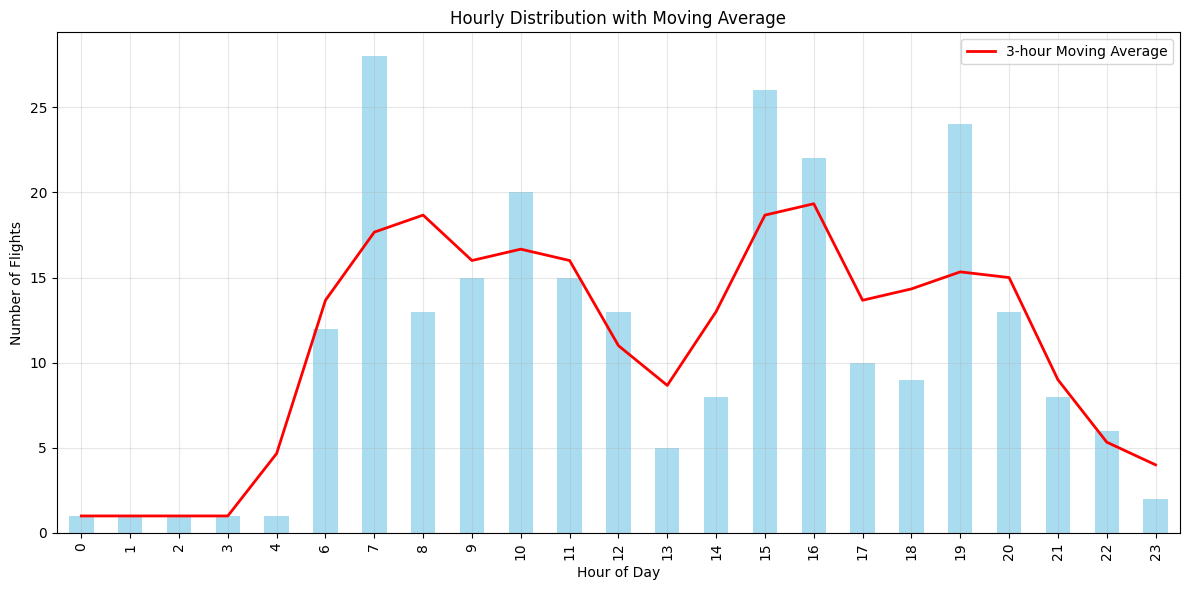

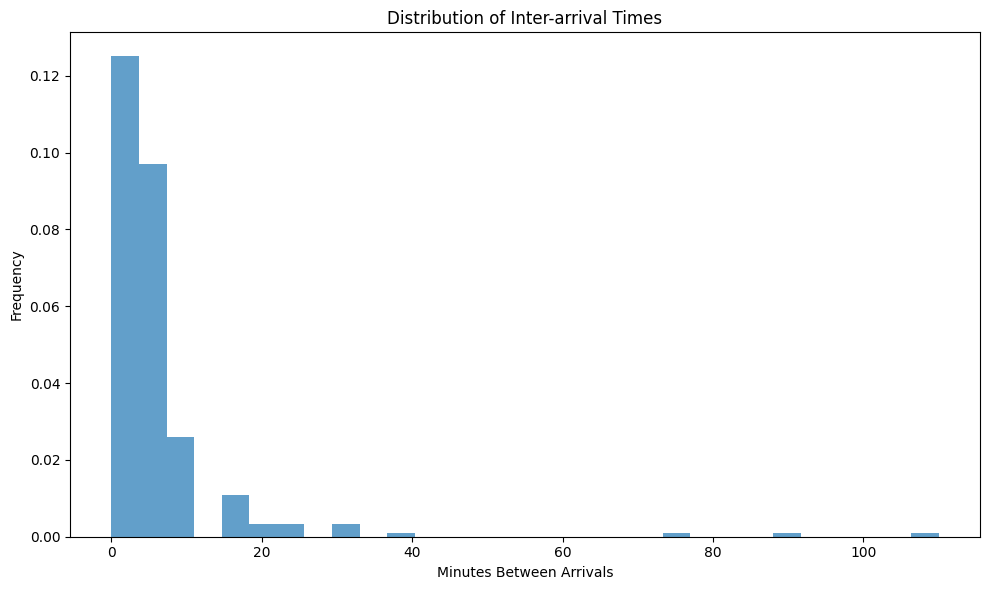

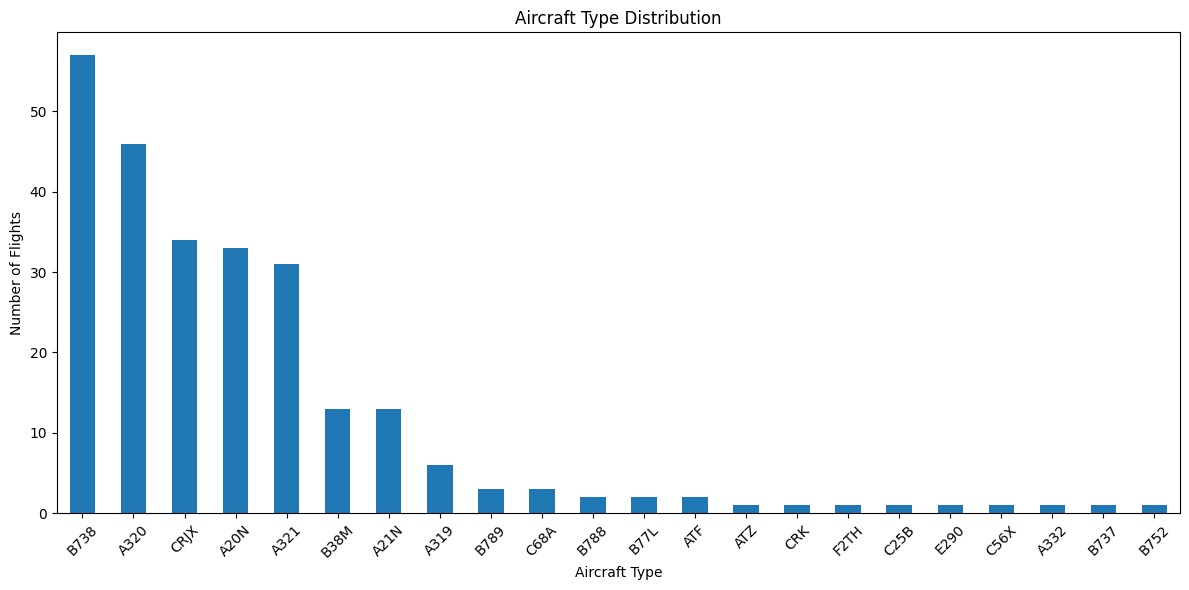


=== Airport Operations Statistics ===

Time-Based Statistics:
Peak Hour: 7.00
Peak Hour Flights: 28.00
Average Flights per Hour: 11.04
Std Dev Flights per Hour: 8.51

Inter-arrival Time Statistics (minutes):
count    253.000000
mean       5.454545
std       11.369118
min        0.000000
25%        0.000000
50%        5.000000
75%        5.000000
max      110.000000
Name: inter_arrival_minutes, dtype: float64

Aircraft Mix:
B738: 22.4%
A320: 18.1%
CRJX: 13.4%
A20N: 13.0%
A321: 12.2%
B38M: 5.1%
A21N: 5.1%
A319: 2.4%
B789: 1.2%
C68A: 1.2%
B788: 0.8%
B77L: 0.8%
ATF: 0.8%
ATZ: 0.4%
CRK: 0.4%
F2TH: 0.4%
C25B: 0.4%
E290: 0.4%
C56X: 0.4%
A332: 0.4%
B737: 0.4%
B752: 0.4%

Modeling Parameters:
Mean Inter-arrival Time: 5.45 minutes
Inter-arrival Time Std Dev: 11.37 minutes

Poisson Distribution Test failed: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are

In [15]:
# Import required libraries
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

# Set default style
plt.style.use('default')

def create_flight_statistics(df_schengen):
    """Calculate basic flight statistics"""
    # Convert time to datetime
    df_schengen['datetime'] = pd.to_datetime(df_schengen['date'] + ' ' + df_schengen['time'])
    
    # Calculate hourly flights
    hourly_flights = df_schengen.groupby(df_schengen['datetime'].dt.hour).size()
    
    # Calculate time-based statistics
    time_stats = {
        'Peak Hour': hourly_flights.idxmax(),
        'Peak Hour Flights': hourly_flights.max(),
        'Average Flights per Hour': hourly_flights.mean(),
        'Std Dev Flights per Hour': hourly_flights.std()
    }
    
    # Calculate inter-arrival times
    df_sorted = df_schengen.sort_values('datetime')
    df_sorted['next_arrival'] = df_sorted['datetime'].shift(-1)
    df_sorted['inter_arrival_minutes'] = (df_sorted['next_arrival'] - df_sorted['datetime']).dt.total_seconds() / 60
    
    return hourly_flights, time_stats, df_sorted

def plot_flight_distributions(hourly_flights, df_schengen):
    """Create visualizations for flight data"""
    # 1. Hourly Distribution
    plt.figure(figsize=(12, 6))
    hourly_flights.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.plot(range(len(hourly_flights)), 
             hourly_flights.rolling(3, center=True, min_periods=1).mean(), 
             'r-', linewidth=2, label='3-hour Moving Average')
    plt.title('Hourly Distribution with Moving Average')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Flights')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Inter-arrival Time Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df_schengen['inter_arrival_minutes'].dropna(), 
             bins=30, density=True, alpha=0.7)
    plt.title('Distribution of Inter-arrival Times')
    plt.xlabel('Minutes Between Arrivals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # 3. Aircraft Type Distribution
    plt.figure(figsize=(12, 6))
    aircraft_stats = df_schengen['aircraft'].value_counts()
    aircraft_stats.plot(kind='bar')
    plt.title('Aircraft Type Distribution')
    plt.xlabel('Aircraft Type')
    plt.ylabel('Number of Flights')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_statistics(df_schengen, time_stats, hourly_flights):
    """Print statistical summary with improved Poisson test"""
    print("\n=== Airport Operations Statistics ===")
    print("\nTime-Based Statistics:")
    for key, value in time_stats.items():
        print(f"{key}: {value:.2f}")

    print("\nInter-arrival Time Statistics (minutes):")
    print(df_schengen['inter_arrival_minutes'].describe())

    aircraft_stats = df_schengen['aircraft'].value_counts()
    aircraft_percentages = (aircraft_stats / len(df_schengen)) * 100
    print("\nAircraft Mix:")
    for aircraft, percentage in aircraft_percentages.items():
        print(f"{aircraft}: {percentage:.1f}%")

    print("\nModeling Parameters:")
    print(f"Mean Inter-arrival Time: {df_schengen['inter_arrival_minutes'].mean():.2f} minutes")
    print(f"Inter-arrival Time Std Dev: {df_schengen['inter_arrival_minutes'].std():.2f} minutes")

    # Improved Poisson distribution test
    try:
        # Calculate expected frequencies
        hourly_lambda = hourly_flights.mean()
        hours = len(hourly_flights)
        expected = stats.poisson.pmf(range(max(hourly_flights) + 1), hourly_lambda)
        expected = expected * sum(hourly_flights)
        
        # Prepare observed frequencies
        observed = hourly_flights.value_counts().sort_index()
        
        # Ensure observed and expected have same length
        idx = range(max(observed.index) + 1)
        observed = pd.Series(0, index=idx).add(observed, fill_value=0)
        expected = expected[:len(observed)]
        
        # Perform chi-square test
        chi_square_stat, p_value = stats.chisquare(observed, expected)
        
        print(f"\nPoisson Distribution Test:")
        print(f"Chi-square statistic: {chi_square_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Follows Poisson distribution: {p_value > 0.05}")
        
    except Exception as e:
        print(f"\nPoisson Distribution Test failed: {str(e)}")
        print("Cannot determine if arrivals follow Poisson distribution")

# Run the analysis
hourly_flights, time_stats, df_schengen = create_flight_statistics(df_schengen)
plot_flight_distributions(hourly_flights, df_schengen)
print_statistics(df_schengen, time_stats, hourly_flights)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from io import StringIO
import contextlib

def generate_pdf_report(df_schengen, output_path='results/plots/flight_statistics.pdf'):
    """Generate PDF report with flight statistics and visualizations"""
    with PdfPages(output_path) as pdf:
        # Capture print output
        output = StringIO()
        with contextlib.redirect_stdout(output):
            hourly_flights, time_stats, df_sorted = create_flight_statistics(df_schengen)
            print_statistics(df_sorted, time_stats, hourly_flights)
        text_output = output.getvalue()
        
        # Create text figure
        fig_text = plt.figure(figsize=(12, 8))
        plt.text(0.1, 0.1, text_output, family='monospace', fontsize=10)
        plt.axis('off')
        pdf.savefig(fig_text)
        plt.close()
        
        # Create distribution plots
        # 1. Hourly Distribution
        fig1 = plt.figure(figsize=(12, 6))
        hourly_flights.plot(kind='bar', color='skyblue', alpha=0.7)
        plt.plot(range(len(hourly_flights)), 
                 hourly_flights.rolling(3, center=True, min_periods=1).mean(), 
                 'r-', linewidth=2, label='3-hour Moving Average')
        plt.title('Hourly Distribution with Moving Average')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Flights')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        pdf.savefig(fig1)
        plt.close()

        # 2. Inter-arrival Time Distribution
        fig2 = plt.figure(figsize=(10, 6))
        plt.hist(df_sorted['inter_arrival_minutes'].dropna(), 
                 bins=30, density=True, alpha=0.7)
        plt.title('Distribution of Inter-arrival Times')
        plt.xlabel('Minutes Between Arrivals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        pdf.savefig(fig2)
        plt.close()

        # 3. Aircraft Type Distribution
        fig3 = plt.figure(figsize=(12, 6))
        aircraft_stats = df_sorted['aircraft'].value_counts()
        aircraft_stats.plot(kind='bar')
        plt.title('Aircraft Type Distribution')
        plt.xlabel('Aircraft Type')
        plt.ylabel('Number of Flights')
        plt.xticks(rotation=45)
        plt.tight_layout()
        pdf.savefig(fig3)
        plt.close()
        
        print(f"PDF report generated: {output_path}")

# Generate the PDF report
generate_pdf_report(df_schengen, dataset_name + '-flight_statistics.pdf')

PDF report generated: Departures-flight_statistics.pdf
